# Simulating the effects of missing data in *SVDquartets*
In order to explore the effect of missing data on the ability to recover the correct topology in *SVDquartets* a number of ddrad datasets will be simulated, varying levels of data will be convereted to `N`'s, *SVDquartets* will be run, and accuracy will be assessed with the Robinson-Foulds distance. Here is a brief outline:

1. Load modules, make a few useful definitions
2. Simulate datasets
  
 2.1 Define simulation parameters
    * Data type
    * Locus size
    * Number of loci per library
    * Effective population size
    * True tree simulated under
    
 2.2 Run *simRRLs* and *pyRAD*
3. Create missing data replicates
4. Run *SVDquartets*
5. Calculate RF distance

**I highly recommend reading the docs for [*simRRLS*](http://dereneaton.com/radseq/simulating_raw_radseq_data/), [*(i)pyRAD*](http://dereneaton.com/software/pyrad/), and [*ASTRAL-II*](https://github.com/smirarab/ASTRAL/blob/master/astral-tutorial.md). SVDquartets does not have a devoted docs/tutorials page but [Dr. Laura Kubatko's molevol page is very helpful](https://molevol.mbl.edu/index.php/Laura_Kubatko)** 
    

### 1. Load modules, make a few useful definitions

In [85]:
# Handle IO, sysargs, subprocesses
import sys
import os
import shutil
import subprocess
from subprocess import Popen, PIPE
import csv
import glob
import pkg_resources
import argparse 
# Data parsing
import numpy as np
import pandas as pd
import numpy.random as rand
import re
# Bioinformatics
from Bio import AlignIO, Alphabet
import dendropy
from ete3 import Tree, TreeStyle
import simrrls as simrrls
# Parallelization
import logging
from multiprocessing import Pool, Process, current_process, log_to_stderr, cpu_count
from multiprocessing.managers import SyncManager
import signal
# Loading bars and miscellaneous
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint

The next few definitions make our work a little easier and more readable.

In [3]:
def listabs(directory):
    '''Returns the absolute path of all items in a directory
    
    Parameters
    ----------
    directory : path to directory'''
    return [os.path.join(directory, filename) for filename in os.listdir(directory)]

In [4]:
class Vividict(dict):
    '''An infinitely nestable dictionary
    
    Parameters
    -----------
    dict : a dictionary
     '''
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

In [5]:
def remove_all(directory):
    files = glob.glob(directory+'*')
    for f in files:
        if os.path.isdir(f): shutil.rmtree(f)
        else: os.remove(f)

In [6]:
def multiply_strints(mystring, by):
    '''Multiplies all integers in a string by a value.
    
    Parameters
    ----------
    mystring : a string
    by : factor to multiply by '''
    return re.sub(
        re.compile("\d+"), 
        lambda matchobj: str(int(matchobj.group(0))*by), mystring)

In [68]:
flatten = lambda l: [item for sublist in l for item in sublist]

## 2. Simulate datasets

First, let's create and move into a new directory where our simulations will live

In [7]:
print('Current working directory: %s\n') % (os.getcwd())
sim_dir = '/Users/IanGilman/pythonscripts/SimMissingData/'
try: 
    os.mkdir(sim_dir)
    print('Created new simulation directory: %s\n') % (sim_dir)
except OSError: 
    print('Directory %s already exists\n') % (sim_dir)
os.chdir(sim_dir)
print('Current working directory: %s\n') % (os.getcwd())

Current working directory: /Users/IanGilman/pythonscripts

Directory /Users/IanGilman/pythonscripts/SimMissingData/ already exists

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData



### 2.1 Define simulation parameters
Next, we'll define the tree to simulate under. We'll stick with a balanced tree with internal branch lengths of 1.0 coalescent units for now. At the end we'll put everything together to run any number of different topologies/parameters in a parallelized way.

In [8]:
MedBalTree = '(((((A:1,B:1):1,C:2):1,D:3):1,(((E:1,F:1):1,G:2):1,H:3):1):1,(((I:1,J:1):1,K:2):1,L:3):2);'
path = os.path.join(sim_dir, 'MedBalTree')
with open(path, 'w+') as f:
    f.write(MedBalTree)

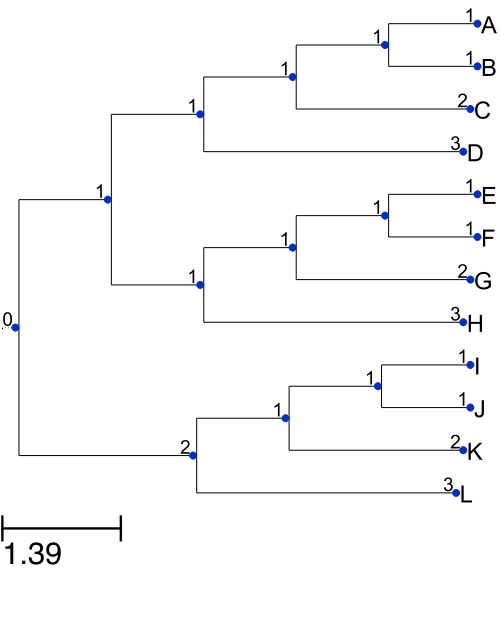

In [150]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
tree = Tree(MedBalTree)
tree.render("%%inline", w =500, tree_style=ts)

Our data set will 200 loci, all of length 100bp, and all taxa will have an effective population size ($N_e$) of $1e5$, which is constant in size.

In [17]:
sim_params = {'n_loci':200, 'locus_size':100, 'Ne':1e5, 'treeshape':'mb', 'treepath':path, 'Ne_cat': 'l'}

Finally, we need a simulation name for output files that's informative about the simulation parameters (for when we have many simulations). I'll stick with a format indicative of the parameters passed to *simRRLs*: `l<locus_size>L<n_loci>S<treeshape>N<Ne>`. I'll refer to $N_e$ as 'l' (low, $1e4$), 'm' (medium, $1e5$), and 'h' (high, $1e6$). Note that 'mb' refers to medium, balanced.

In [18]:
simname = 'l%dL%dS%sN%s' % (sim_params['locus_size'], sim_params['n_loci'], sim_params['treeshape'], 
                            sim_params['Ne_cat'])
print simname

l100L200SmbNl


### 2.2 Run *simRRLs* and *pyRAD*

We'll want to have a separate directory for each simulation.

In [50]:
print('Current working directory: %s\n') % (os.getcwd())
current_simdir = os.path.join('/Users/IanGilman/pythonscripts/SimMissingData/', simname)
try: 
    os.mkdir(current_simdir)
    print('Created new simulation directory: %s\n') % (current_simdir)
except OSError: 
    print('Directory %s already exists\n') % (current_simdir)
os.chdir(current_simdir)
print('Current working directory: %s\n') % (os.getcwd())

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl

Directory /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl already exists

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl



**Run *simRRLs***

I'm interested in ddRAD because of my empirical work in *Chloropyron* (Orobanchaceae), but RAD, GBS, paired-end ddRAD, and paired-end GBS can also be simulated. Here's what our command would look like entered into the command line:

In [52]:
simrrlls_call = '-o %s -f ddrad -l %d -L %d -N %s -t %s' % (simname, 
                                                            sim_params['locus_size'], 
                                                            sim_params['n_loci'],
                                                            sim_params['Ne'],
                                                            sim_params['treepath'])
print("bash\n>> %s") % (simrrlls_call)

bash
>> -o l100L200SmbNl -f ddrad -l 100 -L 200 -N 100000.0 -t /Users/IanGilman/pythonscripts/SimMissingData/MedBalTree


In [55]:
run_simrrls = Popen(['simrrls', '-o', simname, 
                      '-f', 'ddrad', 
                      '-l', str(sim_params['locus_size']), 
                      '-L', str(sim_params['n_loci']), 
                      '-N', str(sim_params['Ne']),
                      '-t', sim_params['treepath']], 
                     stdin=PIPE, stdout=PIPE, stderr=PIPE)

**Run *pyRAD***

To run *pyRAD* we'll first need to create a params file. We'll create one, slightly change the barcode file from *simRRLs* so it's recognized by default by *pyRAD*, and change a few settings. For the purpose of our study, we'll change the restriction overhang, number of processors, datatype, output prefix, and output formats.

In [60]:
new_params_call = 'pyrad -n' 
print("bash\n>> %s") % (new_params_call)
create_new_params = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-n'], stdin=PIPE, stdout=PIPE, stderr=PIPE)

bash
>> pyrad -n


In [62]:
old_bc_file = simname+'_barcodes.txt'
new_bc_file = simname+'.barcodes'
if not os.path.exists(new_bc_file):
    shutil.move(old_bc_file, new_bc_file)

In [65]:
# Read old lines
with open('params.txt', 'r') as p:
    paramsdata =  p.readlines()

# Edit lines
newlines = []
for line in paramsdata:
    if 'Restriction overhang' in line:
        line = 'CTGCAG, CCGG                     ## 6. Restriction overhang (e.g., C|TGCAG -> TGCAG)     (s1,s2)\n'
    if 'N processors' in line:
        line = '%d                         ## 7. N processors (parallel)                           (all)\n' % (cpu_count())
    if 'Datatype' in line:
        line = 'ddrad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)\n'
    if 'Prefix name' in line:
        line = '%s.c88d6m4p3                 ## 14. Prefix name for final output (no spaces)         (s7)\n' % (simname)
    if 'output formats' in line:
        line = '*                       ## 30.opt.: output formats: p,n,a,s,v,u,t,m,k,g,* (see docs) (s7)\n'
    newlines.append(line)

# Write new lines
with open('params.txt', 'w') as p:
    p.writelines(newlines)

Now we're ready to run *pyRAD*

In [67]:
pyrad_call = 'pyrad -p params.txt -s 1234567' 
print("bash\n>> %s") % (pyrad_call)
run_pyrad = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-p', 'params.txt', '-s', '1234567'], 
                  stdin=PIPE, stdout=PIPE, stderr=PIPE)

bash
>> pyrad -p params.txt -s 1234567


### 3. Create missing data replicates

With our output files in hand, we can now randomly remove data. We'll work with phylip files for simplicity, but have to convert back to nexus for input into PAUP*. We'll begin by reading a phylip file into a DataFrame.

In [73]:
# Read phylip data
phylip = './outfiles/%s.c88d6m4p3.phy' % (simname)
with open(phylip, 'r') as p:
    phylipdata = p.readlines()

# Split all sites 
splitdata = []
for line in phylipdata[1:]:
    splitdata.append(line.split())
for i, line in enumerate(splitdata):
    splitdata[i][1] = list(splitdata[i][1])    
flatdata = []
for line in splitdata:
    flatdata.append([line[0]]+line[1])

# Write to dataframe
datadf = pd.DataFrame(flatdata)
datadf.set_index(keys=[0], inplace=True)

datadf

,1,2,3,4,5,6,7,8,9,10,...,16991,16992,16993,16994,16995,16996,16997,16998,16999,17000
0,,,,,,,,,,,,,,,,,,,,,
A_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
B_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
C_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
D_0,T,G,A,T,T,T,C,S,C,G,...,A,G,T,G,C,G,G,A,C,T
E_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
F_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
G_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
H_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
I_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T


For now, we'll remove 50% of the data, but in the full program we'd loop over many rates of missing data. To keep track of these unique datasets we'll add a prefix to our filenames.

In [77]:
percent = 50
# Create string for naming files
p = '.p'+str(percent).zfill(2)

# Get number of entries
entries = datadf.shape[0]*datadf.shape[1]

# Substitute rand percent with 'N'
if percent==0: missingdf=datadf
else: missingdf = datadf.where(np.random.uniform(size=datadf.shape) > float(percent/100.), 'N')

missingdf

,1,2,3,4,5,6,7,8,9,10,...,16991,16992,16993,16994,16995,16996,16997,16998,16999,17000
0,,,,,,,,,,,,,,,,,,,,,
A_0,N,N,A,T,T,N,C,N,N,G,...,N,G,T,G,N,G,N,N,N,T
B_0,N,N,A,N,T,N,N,N,C,G,...,A,G,T,N,C,G,N,A,C,N
C_0,N,G,A,N,N,N,N,N,C,G,...,A,G,T,N,C,N,N,A,C,T
D_0,T,G,A,T,N,T,N,S,C,G,...,N,N,T,N,C,G,N,N,N,N
E_0,T,N,A,N,N,T,N,N,N,N,...,A,G,N,N,N,N,N,N,C,N
F_0,T,G,A,T,T,T,N,C,C,N,...,A,G,T,G,N,G,G,N,C,T
G_0,T,G,A,T,T,N,C,N,N,N,...,N,G,N,N,C,G,G,A,N,N
H_0,T,G,N,N,T,N,N,N,C,N,...,N,G,N,G,N,N,N,A,C,N
I_0,N,G,A,N,T,T,C,C,C,G,...,N,N,T,G,C,G,N,N,C,N


In [132]:
# Convert dataframe to sequence strings
missinglines =[]
meta = ('%d %d\n') % (datadf.shape[0], datadf.shape[1])
missinglines.append(meta)
for i in xrange(len(missingdf)):
    missinglines.append('       '.join([missingdf.index[i],''.join(missingdf.ix[i])])+'\n')
    
# Write strings to phylip file
with open(simname+p+'.phy', 'w+') as m:
    m.writelines(missinglines)
    missing_phy = simname+p+'.phy'
    print('Wrote %d percent missing data phylip file to %s') % (percent, missing_phy)

# Convert phlyip to nexus for PAUP
alignment = AlignIO.read(open(simname+p+'.phy'), "phylip", alphabet=Alphabet.generic_dna)
with open(simname+p+'.nex', "w+") as n:
    n.write(alignment.format("nexus"))
    missing_nex = simname+p+'.nex'
    print('Wrote %d missing data nexus file to %s') % (percent, missing_nex)

Wrote 50 percent missing data phylip file to l100L200SmbNl.p50.phy
Wrote 50 missing data nexus file to l100L200SmbNl.p50.nex


### 4. Run *SVDquartets*

To run *SVDquartets* we'll have to add a PAUP block to our nexus file. This will specify that we want to PAUP to 

1. autoclose after finishing
2. run SVDquartets
    * all quartets analyzed
    * missing data set to 'Missing'
3. save the output as newick trees

Here's an example:

    BEGIN PAUP;
        set autoclose=yes;
        SVDquartets evalQuartets=all ambigs=missing;
        SaveTrees file=FILENAME format=Newick;
        quit;
    End;

In [133]:
saveline = '\tSaveTrees file=%s.tre format=Newick brLens=no;\n' % (simname)
paup_lines = ['\nBEGIN PAUP;\n', '\tset autoclose=yes;\n', 
              '\tSVDquartets evalQuartets=all ambigs=missing;\n',
              saveline, '\tquit;\n', 'End;\n']

with open(missing_nex, 'a') as n:
        n.writelines(paup_lines)

Finally, let's run *SVDquartets*. We'll set PAUP* to 'non-interactive' mode.

In [134]:
svdquartets_call = 'paup4 -n %s' % (missing_nex)
print("bash\n>> %s") % (svdquartets_call)
run_svdquartets = Popen(['paup4', '-n', missing_nex], stdin=PIPE, stdout=PIPE, stderr=PIPE)

bash
>> paup4 -n l100L200SmbNl.p50.nex


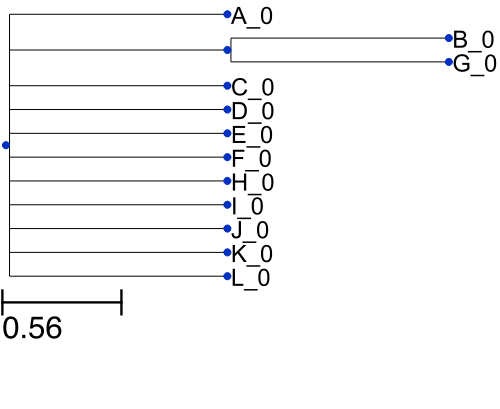

In [146]:
ts = TreeStyle()
ts.show_leaf_name = True
p50_tree = Tree('./l100L200SmbNl.tre')
p50_tree.render("%%inline", w =500, tree_style=ts)

### 4. Calculate Robinson-Foulds distance

To assess the accuracy of our estimated species tree I will use the normalized Robinson-Foulds (RF) distance (Robinson and Foulds 1981). This measures the number of bipartitions in our true tree that are not present in out estimated tree, and the number of biparitions in our estimated tree that are not present in the true tree. It has a maximum value of $2(n-3)=18$ for our 12-taxon tree. For generality, we will normalize our RF distances by this value.

For various reasons, I'm using DendroPy 3.12, and we *actually* want to use the `symmetric_difference`, not `robinson_foulds_distance` function because we do not have branch lengths. In addition, there is a [known error](https://github.com/jeetsukumaran/DendroPy/issues/14) in behavior of this function. I wrote the work around suggest by Jeet Sukumaran below as a function.

In [154]:
def sym_diff(t1, t2):
    '''This is a fix version of the symmetric difference function in Dendropy written by Jeet Sukumaran
    (see his GitHub)
    
    Parameters
    ----------
    t1 : first tree path
    t2 : second tree path'''
    
    taxon_namespace = dendropy.TaxonSet()
    
    t1 = dendropy.Tree.get_from_path(t1, "newick", taxon_set=taxon_namespace)
    t2 = dendropy.Tree.get_from_path(t2, "newick", taxon_set=taxon_namespace)
    t1.is_rooted
    t2.is_rooted
    t1.symmetric_difference(t2)
    t1.symmetric_difference(t2)

    return t2.symmetric_difference(t1)

In [158]:
RF = sym_diff(t1='./l100L200SmbNl.tre', t2 = '../MedBalTree')
norm_RF = sym_diff(t1='./l100L200SmbNl.tre', t2 = '../MedBalTree')/18.
print(RF, norm_RF)

(13, 0.7222222222222222)


Now that we've been through one iteration using one set of parameters we'd like to 

In [394]:
print(os.getcwd())

## Loop over all combinations
for i, combo in tqdm_notebook(enumerate(combos[:10]), desc='Simulation'):
    
    ## For convenience
    size = combo[0]
    number = combo[1]
    shape = combo[2]
    ne = combo[3]
    
    # Create tree object from true topology
    truetree = dendropy.Tree.get_from_string(treeshapes[shape]['tree'], schema='newick')
    
    # Create dict to fill of tree distances
    percents = ['p'+str(rate).zfill(3) for rate in range(0,95, 10)]
    treedist = {}
    for key in percents:
        treedist[key] = []

    ## Create simulation name
    print('\nSimulation %d\nN loci:%d\nLocus length: %d\nTree shape: %s\nNe: %s\n') % (i+1, number, size, shape, ne)
    simname = 'l%sL%sS%sN%s' % (size, number, shape, ne)
    print('Simulation name: %s') % (simname)
    
    ## Create/move to simulation directory
    cursimdir = os.path.join(newsimsdir, simname)
    try: 
        os.mkdir(cursimdir)
        print('Created directory %s') % (cursimdir)
    except OSError: print('Directory %s exists') % (cursimdir)
    os.chdir(cursimdir)
    print('Current working directory: %s\n') % (os.getcwd())
    
    ## Run simulation and pyRAD if not already done
    if not os.path.exists(simname+'_R1_.fastq.gz'):
        run_simrrls(size=size, nloci=number, shape=shape, ne=ne, simname=simname)
    else: print('Dataset %s already simulated. Move/remove it to rerun. Continuing to pyRAD...\n') % (simname)
    run_pyrad(simname)
    print('... pyRAD finished.\n')
    
    ## Want to create and analyze 10 replicates of missing data
    ## Create missing data datasets
    print('Creating missing data datsets...\n')
    # Read phylip file to datframe 
    fulldata = phylip_to_df(simname=simname)
    
    print('Running SVDquartets and calculating RF distances...\n')
    for i in tqdm_notebook(range(10), desc='Missing data replicates', leave = False):
        # Write/replace nexus files and append PAUP blocks
        for mp in tqdm_notebook(range(0, 95, 10), desc='Percent missing', leave=False):
            nexusfile = write_missing_data(fulldf=fulldata, percent=mp, simname=simname)
            write_svdq_block(nexus=nexusfile, percent=mp)

        nexusfiles = [filename for filename in os.listdir(os.getcwd()) if filename.endswith('.nex')]
        for nexfile in tqdm_notebook(nexusfiles, desc='SVDquartets', leave=False):
            mp = nexfile.split('.')[1]
            run_svdq_call = 'paup4 -n %s' % (nexfile)
            subprocess.call(run_svdq_call, shell=True)

        treefiles = [filename for filename in os.listdir(os.getcwd()) if filename.endswith('.tre')]
        for tree in treefiles:
            key = tree.split('.')[0]
            t = dendropy.Tree.get_from_path(tree, schema='nexus')
            t.symmetric_difference(truetree)
            try: treedist[key].append(truetree.symmetric_difference(t))
            except KeyError: continue
    
    pprint(treedist)
    pd.DataFrame.from_dict(treedist).to_csv(path_or_buf=simname+'.RF.csv')
    
    print('\nFinished. RF distances written to %s\n') % (simname+'.RF.csv')

/Users/IanGilman/.Trash/l100L100SlbNh 1.39.31 PM

Simulation 1
N loci:100
Locus length: 100
Tree shape: mb
Ne: h

Simulation name: l100L100SmbNh
Created directory /Users/IanGilman/simrrls/newsims/l100L100SmbNh
Current working directory: /Users/IanGilman/simrrls/newsims/l100L100SmbNh

Running simrrls...
simrrls -o l100L100SmbNh -f ddrad -l 100 -L 100 -t /Users/IanGilman/simrrls/MedBalTree -N 900000.0

Dataset l100L100SmbNh finished.

python ~/pyrad/pyrad/pyRAD.py -p params.txt -s 1234567
... pyRAD finished.

Creating missing data datsets...

Running SVDquartets and calculating RF distances...

{'p000': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p010': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p020': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p030': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p040': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p050': [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
 'p060': [0, 0, 6, 0, 0, 2, 0, 0, 2, 0],
 'p070': [0, 0, 0, 2, 0, 0, 0, 2, 2, 4],
 'p080': [6, 6, 8, 10, 8, 12, 16, 10, 8, 16],
 'p090': [18, 16, 18, 18, 

KeyboardInterrupt: 

## 5. Run GARLI
For all loci from all runs we will run GARLI to create input for ASTRAL

* Read in GARLI.conf example from `~/Garli/example/basic/garli.conf`
* Make list of all directories
* For each directory, `cd` and make list of nexus files
* For each nexus file create a new garli.conf file
    * 
* Run GARLI for 5 trees? This is 60 (datasets) x 16 (missing data rates) x 5 (trees)= 4800 trees to estimate

## 6. Copy all files to directory for ASTRAL analysis

In [5]:
1e5

100000.0

In [67]:
ShortBalTree = multiply_strints(MedBalTree, 0.5)
LongBalTree = multiply_strints(MedBalTree, 2.0)

In [68]:
treeshapes = Vividict()
treeshapes['ShortBalTree']['tree'] = ShortBalTree
treeshapes['MedBalTree']['tree'] = MedBalTree
treeshapes['LongBalTree']['tree'] = LongBalTree

In [69]:
for key in treeshapes.iterkeys():
    path = os.path.join(sim_dir, key)
    treeshapes[key]['path'] = str(path)
    with open(path, 'w+') as f:
        f.write(treeshapes[key]['tree'])

In [70]:
treeshapes['sb'] = treeshapes.pop('ShortBalTree')
treeshapes['mb'] = treeshapes.pop('MedBalTree')
treeshapes['lb'] = treeshapes.pop('LongBalTree')

In [71]:
print treeshapes

{'mb': {'path': '/Users/IanGilman/pythonscripts/SimMissingData/MedBalTree', 'tree': '(((((A:1,B:1):1,C:2):1,D:3):1,(((E:1,F:1):1,G:2):1,H:3):1):1,(((I:1,J:1):1,K:2):1,L:3):2);'}, 'lb': {'path': '/Users/IanGilman/pythonscripts/SimMissingData/LongBalTree', 'tree': '(((((A:2.0,B:2.0):2.0,C:4.0):2.0,D:6.0):2.0,(((E:2.0,F:2.0):2.0,G:4.0):2.0,H:6.0):2.0):2.0,(((I:2.0,J:2.0):2.0,K:4.0):2.0,L:6.0):4.0);'}, 'sb': {'path': '/Users/IanGilman/pythonscripts/SimMissingData/ShortBalTree', 'tree': '(((((A:0.5,B:0.5):0.5,C:1.0):0.5,D:1.5):0.5,(((E:0.5,F:0.5):0.5,G:1.0):0.5,H:1.5):0.5):0.5,(((I:0.5,J:0.5):0.5,K:1.0):0.5,L:1.5):1.0);'}}


In [10]:
nloci = [100, 200]
lengths = [100, 200]
Nes = {'l':100, 'm': 1000, 'h':10000}

combos = []
for number in nloci:
    for size in lengths:
        for shape in treeshapes.keys():
            for Ne in Nes.keys():
                combos.append([size, number, shape, Ne])
print(len(combos))
# print combos

540
[[100, 100, 'mb', 'h'], [100, 100, 'mb', 'm'], [100, 100, 'mb', 'l'], [100, 100, 'su', 'h'], [100, 100, 'su', 'm'], [100, 100, 'su', 'l'], [100, 100, 'lb', 'h'], [100, 100, 'lb', 'm'], [100, 100, 'lb', 'l'], [100, 100, 'mu', 'h'], [100, 100, 'mu', 'm'], [100, 100, 'mu', 'l'], [100, 100, 'lu', 'h'], [100, 100, 'lu', 'm'], [100, 100, 'lu', 'l'], [100, 100, 'sb', 'h'], [100, 100, 'sb', 'm'], [100, 100, 'sb', 'l'], [200, 100, 'mb', 'h'], [200, 100, 'mb', 'm'], [200, 100, 'mb', 'l'], [200, 100, 'su', 'h'], [200, 100, 'su', 'm'], [200, 100, 'su', 'l'], [200, 100, 'lb', 'h'], [200, 100, 'lb', 'm'], [200, 100, 'lb', 'l'], [200, 100, 'mu', 'h'], [200, 100, 'mu', 'm'], [200, 100, 'mu', 'l'], [200, 100, 'lu', 'h'], [200, 100, 'lu', 'm'], [200, 100, 'lu', 'l'], [200, 100, 'sb', 'h'], [200, 100, 'sb', 'm'], [200, 100, 'sb', 'l'], [300, 100, 'mb', 'h'], [300, 100, 'mb', 'm'], [300, 100, 'mb', 'l'], [300, 100, 'su', 'h'], [300, 100, 'su', 'm'], [300, 100, 'su', 'l'], [300, 100, 'lb', 'h'], [300, 